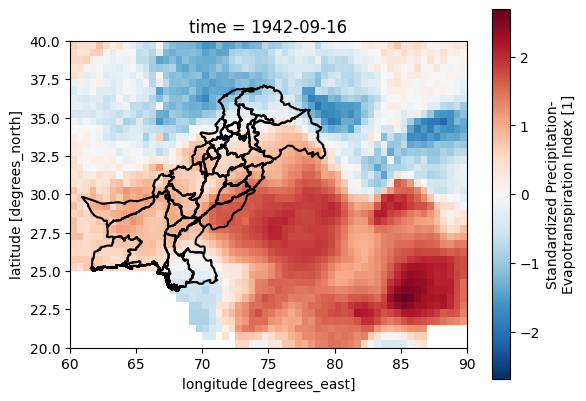

In [2]:
import matplotlib.pyplot as plt
import xarray as xr 
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

dataset = xr.open_dataset("nc files/pak_spei03.nc")
shapefile = gpd.read_file("shapefile/Pak_adm2.shp", crs = "epsg:4326")


fig, ax = plt.subplots()


shapefile.boundary.plot(ax=ax, color = 'black')
dataset['spei'].isel(time = 500).plot(ax=ax)

df = dataset.mean(dim = ['lon', 'lat']).to_dataframe().reset_index()
df['time'] = pd.to_datetime(df['time'])
df = df.loc[df['time'].dt.year>2005]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=df['time'].loc[df['spei']>0],
    y=df['spei'].loc[df['spei']>0],
    name='flood',
    marker_color='blue'
))
fig.add_trace(go.Bar(
    x=df['time'].loc[df['spei']<0],
    y=df['spei'].loc[df['spei']<0],
    name='drought',
    marker_color='red'
))



# Set x and y labels
fig.update_layout(
    xaxis_title='Time',
    yaxis_title='SPEI', 
    title = f'SPEI_03'
)

fig.update_layout(barmode='group', xaxis_tickangle=-45)
plt.show()
fig.show()


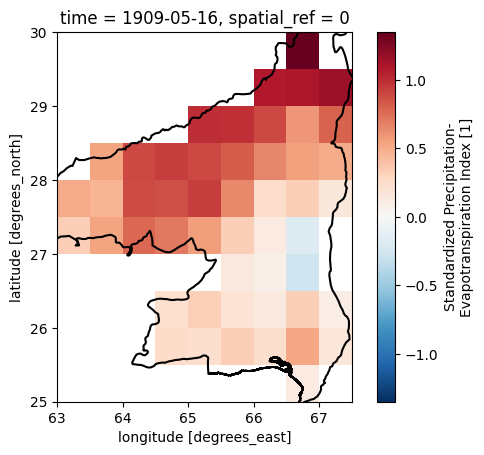

In [3]:
dataset = xr.open_dataset("nc files/pak_spei03.nc")
shapefile = gpd.read_file("shapefile/Pak_adm2.shp", crs = "epsg:4326")

fig, ax = plt.subplots() 
division = 'Kalat'

shapefile = shapefile.loc[shapefile['ENGTYPE_2'] == division]


dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
dataset.rio.write_crs("epsg:4326", inplace=True)
dataset = dataset.rio.clip(shapefile.geometry, shapefile.crs, drop=True)
shapefile.boundary.plot(ax=ax, color = 'black')

dataset['spei'].isel(time = 100).plot()



df = dataset.mean(dim = ['lon', 'lat']).to_dataframe().reset_index()
df['time'] = pd.to_datetime(df['time'])
df = df.loc[df['time'].dt.year>2005]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=df['time'].loc[df['spei']>0],
    y=df['spei'].loc[df['spei']>0],
    name='flood',
    marker_color='blue'
))
fig.add_trace(go.Bar(
    x=df['time'].loc[df['spei']<0],
    y=df['spei'].loc[df['spei']<0],
    name='drought',
    marker_color='red'
))



# Set x and y labels
fig.update_layout(
    xaxis_title='Time',
    yaxis_title='SPEI', 
    title = f'SPEI_03 {division}'
)

fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

c:\Users\kamra\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\features.py:328: ShapeSkipWarning:

Invalid or empty shape None at index 33 will not be rasterized.



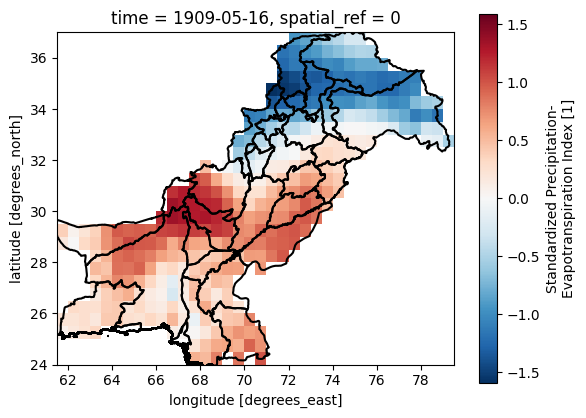

In [31]:
dataset = xr.open_dataset("nc files/pak_spei03.nc")
shapefile = gpd.read_file("shapefile/Pak_adm2.shp", crs = "epsg:4326")

fig, ax = plt.subplots() 
division = 'Kalat'

# shapefile = shapefile.loc[shapefile['ENGTYPE_2'] == division]

dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
dataset.rio.write_crs("epsg:4326", inplace=True)
dataset = dataset.rio.clip(shapefile.geometry, shapefile.crs, drop=True)
shapefile.boundary.plot(ax=ax, color = 'black')
dataset['spei'].isel(time = 100).plot()


CSV File preprocessor

Preparing and preprocessing the csv files for faster runtime computation within the streamlit application

In [4]:
import matplotlib.pyplot as plt
import xarray as xr 
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import functools as ft

division_file_names = {}

shapefile = gpd.read_file("shapefile/PAK_adm2.shp", crs = "epsg:4326")
shapefile = shapefile.loc[~shapefile["ENGTYPE_2"].isna()]
divisions = shapefile["ENGTYPE_2"].values.tolist() 

for division in divisions: 

    if (division == "Islamabad" or division == "Rann of Kutch"):
        continue

    division_dfs = []
    print(f"Working on {division}")

    for nc_file in ['pak_spei03.nc', 'pak_spei06.nc', 'pak_spei09.nc', 'pak_spei12.nc']:
        # Retrieving only the division geometry 
        division_geometry = shapefile.loc[shapefile["ENGTYPE_2"] == division]

        # Getting the spei variant
        spei_variant = nc_file.split("_")[1].split(".")[0]
        # reading the spei dataset
        dataset = xr.open_dataset(f'nc files/{nc_file}')

        # Clipping the dataset with the division geometry
        dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        dataset.rio.write_crs("epsg:4326", inplace=True)
        dataset = dataset.rio.clip(division_geometry.geometry, shapefile.crs, drop=True)

        df = dataset.mean(dim = ['lon', 'lat']).to_dataframe().reset_index()
        df['time'] = pd.to_datetime(df['time'])
        df = df.rename(columns = {"spei": spei_variant})
        df = df[['time', spei_variant]]
        
        division_dfs.append(df)

        # break 
    df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='time'), division_dfs)
    division_file_names[division] =f"{division.replace(".","").replace(" ", "_")}.csv"
    df_final.to_csv(f"csv files/{division_file_names[division]}")
    # break



Working on Azad Kashmir
Working on Kalat
Working on Makran
Working on Nasirabad
Working on Quetta
Working on Sibi
Working on Zhob
Working on F.A.T.A.
Working on Bannu
Working on Dera Ismail Khan
Working on F.A.T.A.
Working on Hazara
Working on Kohat
Working on Malakand
Working on Mardan
Working on Peshawar
Working on Northern Areas
Working on Bahawalpur
Working on Dera Ghazi Khan
Working on Faisalabad
Working on Gujranwala
Working on Lahore
Working on Multan
Working on Rawalpindi
Working on Sargodha
Working on Hyderabad
Working on Karachi
Working on Larkana
Working on Mirpur Khas
Working on Sukkur
Working on Kashmir


In [9]:
pd.DataFrame(data = {"Division": division_file_names.keys(), "File Name": division_file_names.values()}).to_csv("DivisionFileNames.csv")

# division_file_names.values()

In [10]:
shapefile

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,tmp,geometry
0,171,PAK,Pakistan,1,AzadKashmir,1,Azad Kashmir,Division,Azad Kashmir,None,None,Azad Kashmir,"POLYGON ((74.64930 35.13991, 74.66885 35.12403..."
1,171,PAK,Pakistan,2,Kalat,2,Baluchistan,Division,Kalat,None,None,Kalat,"MULTIPOLYGON (((66.60542 24.90264, 66.60542 24..."
2,171,PAK,Pakistan,2,Makran,3,Baluchistan,Division,Makran,None,None,Makran,"MULTIPOLYGON (((63.85486 25.12736, 63.85486 25..."
3,171,PAK,Pakistan,2,Nasirabad,4,Baluchistan,Division,Nasirabad,None,None,Nasirabad,"POLYGON ((67.47849 29.96182, 67.49126 29.94335..."
4,171,PAK,Pakistan,2,Quetta,5,Baluchistan,Division,Quetta,None,None,Quetta,"POLYGON ((67.00654 31.29344, 67.01110 31.29306..."
5,171,PAK,Pakistan,2,Sibi,6,Baluchistan,Division,Sibi,None,None,Sibi,"POLYGON ((67.73946 30.58522, 67.74562 30.56602..."
6,171,PAK,Pakistan,2,Zhob,7,Baluchistan,Division,Zhob,None,Loralai,Zhob,"POLYGON ((69.87385 31.93534, 69.87064 31.91903..."
7,171,PAK,Pakistan,3,F.A.T.A.,8,F.A.T.A.,Division,F.A.T.A.,None,None,F.A.T.A.,"POLYGON ((71.55066 34.93081, 71.56419 34.91536..."
8,171,PAK,Pakistan,4,Islamabad,9,F.C.T.,Division,Islamabad,None,Capital,Islamabad,"POLYGON ((73.14516 33.80333, 73.17208 33.78874..."
9,171,PAK,Pakistan,5,Bannu,10,N.W.F.P.,Division,Bannu,None,None,Bannu,"POLYGON ((70.81600 33.05213, 70.82430 33.03440..."


In [ ]:
|